In [6]:
import pandas as pd
import glob, os, sys
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import numpy as np

In [7]:
ifiles = sorted(glob.glob('../download_AMeDAS_and_create_IDF/data_download/daily/47646/*.csv'))

dd = []
for f in ifiles[:]:
    #print(f)
    df = pd.read_csv(f, index_col=0, parse_dates=True)
    dd.append(df)


dx = pd.concat(dd)
dx.sort_index(inplace=True)

In [8]:
print(dx.head())

            glp_hPa  slp_hPa  precip-accum_mm  precip-hourmax_mm  \
1980-01-31   1020.6   1024.4              NaN                NaN   
1980-02-01   1023.5   1027.3              0.5                0.5   
1980-02-02   1016.4   1020.2              7.5                2.0   
1980-02-03   1005.8   1009.5              6.0                1.5   
1980-02-04   1008.7   1012.5              4.5                1.0   

            precip-10minmax_mm  temp_C  temp-max_C  temp-min_C  rh_percent  \
1980-01-31                 NaN     4.0         9.7        -3.1        46.0   
1980-02-01                 0.5     2.7         8.9        -6.6        65.0   
1980-02-02                 0.5     6.1         9.8         2.8        88.0   
1980-02-03                 0.5     8.5        12.7         4.9        87.0   
1980-02-04                 0.5     2.7         8.9        -4.0        65.0   

            rh-min_percent  ...  wdir-max_deg  wspd-max-inst_ms  \
1980-01-31            27.0  ...          45.0          

In [9]:
doy = dx.index.day_of_year
dx['doy'] = doy

In [10]:
aa, bb = ['temp_C', 'precip-accum_mm'], ['temp_C']
cc = np.unique(aa+bb)
print(aa)
print(bb)
print(cc)

['temp_C', 'precip-accum_mm']
['temp_C']
['precip-accum_mm' 'temp_C']


precip-accum_mm   1996-10-21
temp_C            1996-09-14
dtype: datetime64[ns]

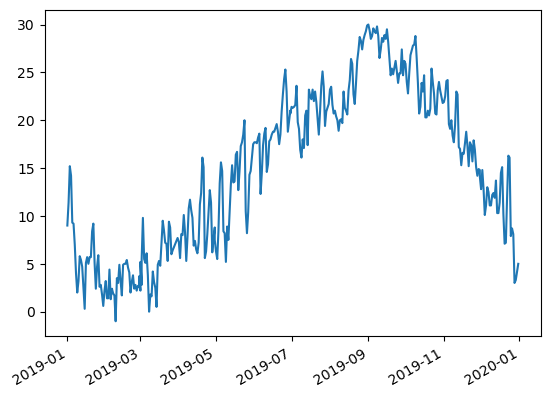

In [11]:
dat = dx[cc].loc['1981':'2020']
dat.loc['2019', 'temp_C'].plot()
dat.idxmax()

In [12]:
#print(dat.head())
dat.isnull().sum() / len(dat)
dat.groupby(dat.index.year).sum()
x = dat.loc[:,'precip-accum_mm']
dat.loc[:,'precip-accum_mm'] = x.fillna(0)
dat.dropna(inplace=True)

#print(x)




In [13]:
dat_scaled = dat.copy()

min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(dat)

In [14]:

dat

,precip-accum_mm,temp_C
1981-01-01,3.5,8.5
1981-01-02,7.5,12.6
1981-01-03,0.0,9.9
1981-01-04,0.0,4.6
1981-01-05,0.0,4.4
...,...,...
2020-12-26,0.0,10.5
2020-12-27,0.0,10.6
2020-12-28,0.0,8.2
2020-12-29,0.0,7.9


In [15]:
dat_scaled.values[:,:] = x_scaled
print(dat_scaled)

            precip-accum_mm    temp_C
1981-01-01         0.018277  0.384824
1981-01-02         0.039164  0.495935
1981-01-03         0.000000  0.422764
1981-01-04         0.000000  0.279133
1981-01-05         0.000000  0.273713
...                     ...       ...
2020-12-26         0.000000  0.439024
2020-12-27         0.000000  0.441734
2020-12-28         0.000000  0.376694
2020-12-29         0.000000  0.368564
2020-12-31         0.000000  0.365854

[14596 rows x 2 columns]


In [16]:
dat_s_train = dat_scaled.loc['1981':'2010']
dat_s_test = dat_scaled.loc['2010':'2020']

X_train, y_train =  dat_s_train[:-1].loc[:, aa ], dat_s_train[1:].loc[:, bb  ]
X_test, y_test =  dat_s_test[:-1].loc[:, aa ], dat_s_test[1:].loc[:, bb ]



In [17]:
from sklearn import linear_model
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor


#tree_model = DecisionTreeRegressor()
#model = linear_model.LinearRegression()
model = MLPRegressor(hidden_layer_sizes=(100), 
                     random_state=1, 
                     activation='relu', 
                     solver='adam', alpha=0.0001, batch_size='auto',
                     max_iter=500)
#DecisionTreeRegressor()

#RandomForestRegressor()

#tree_model.fit(X_train.values, y_train.values)
#model.fit(X_train, y_train)
model.fit(X_train, y_train)


/Users/doan/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1623: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLPRegressor(hidden_layer_sizes=100, max_iter=500, random_state=1)

temp_C    0.0
dtype: float64


<Axes: >

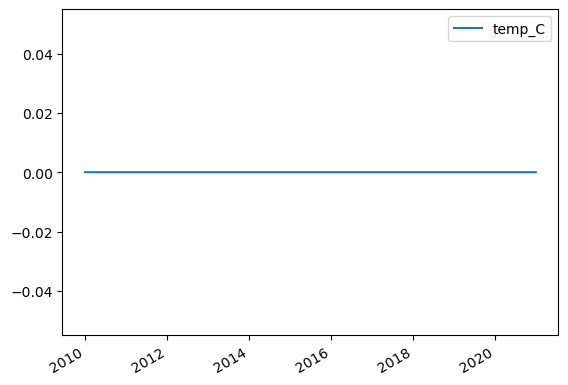

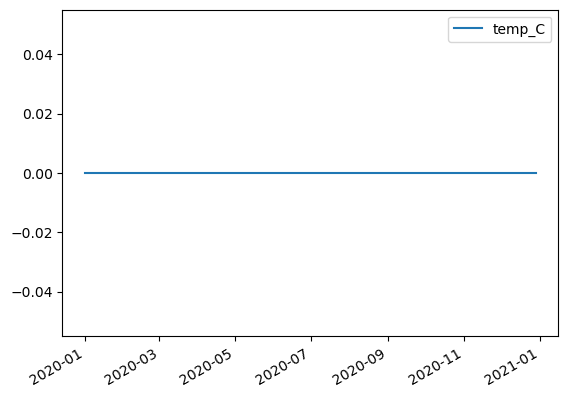

In [20]:
y_pred = model.predict(X_test) #[:,0]


x1 = min_max_scaler.inverse_transform(dat_s_test)[:-1]

xout = dat_s_test[:-1].copy()
xout.loc[:,'precip-accum_mm'] = y_pred


y_predx = min_max_scaler.inverse_transform(xout) - x1

y_pred = pd.DataFrame(y_predx, columns=xout.columns, index = xout.index)
y_pred = y_pred[ bb ]

y_pred.plot()

print((y_pred**2).mean())

y_pred.loc['2020'].plot()
